In [3]:
import os
import torch
import math
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from typing import Tuple, Dict
from bindsnet.network import Network
from bindsnet.learning import PostPre
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

full_resonator_array = torch.Tensor([
    1.1, 1.3, 1.6, 1.9, 2.2, 2.5,
    2.88, 3.05, 3.39, 3.7, 4.12, 4.62,
    5.09, 5.45, 5.87, 6.36, 6.8, 7.6,
    8.6, 10.5, 11.5, 12.8, 15.8, 16.6,
    19.4, 22.0, 24.8, 28.4, 30.5, 34.7,
    37.2, 40.2, 43.2, 47.7, 52.6, 57.2
    ])
bands = {
    'Delta': (.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 32),
    'Gamma': (32, 62),
}


N = 11
xs = (np.array([-.7, -.66, 0, 0.2, 0.4, 0.5, 0.7, 0.7, 0.5, 0.4, 0.2, 0, -.66 ,-.7])+1)/2
ys = (-np.array([0.2, 0.6, .95, 0.6, 0.3, 0.6, 0.2, -0.2, -0.6, -0.3, -0.6, -.95, -0.6, -0.2])+1)/2
channels = ['O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', ]

ch_pos = {
    ch: (x, y)
    for ch, (x, y) in zip(channels, zip(ys, xs))
}

ch_pos_N = {k: (int(x * N), int(y * N)) for k, (x, y) in ch_pos.items()}
map_pos2ch = {(vx, vy): k for k, (vx, vy) in ch_pos_N.items()}
ch_pos_N

{'O2': (4, 1),
 'P8': (2, 1),
 'T8': (0, 5),
 'FC6': (2, 6),
 'F4': (3, 7),
 'F8': (2, 8),
 'AF4': (4, 9),
 'AF3': (6, 9),
 'F7': (8, 8),
 'F3': (7, 7),
 'FC5': (8, 6),
 'T7': (10, 5),
 'P7': (8, 1),
 'O1': (6, 1)}

In [4]:
class Resonators2BandsLayer(Network):

  def __init__(self, channel_name, band_name, clk_freq_resonators: torch.Tensor):
    super().__init__(dt=1)
    self.n_resonators = len(clk_freq_resonators)
    self.band_name = band_name
    self.channel_name = channel_name
    # Layers
    input_layer = Input(
        n=self.n_resonators, shape=(self.n_resonators, ), traces=True, tc_trace=20.0
    )

    agg_layer = LIFNodes(
        n=1,
        traces=False,
        rest=0.0,
        reset=3 * self.n_resonators,
        thresh=5 * self.n_resonators,
        tc_decay=60 * self.n_resonators,
        refrac=1,
    )
    w = torch.where(clk_freq_resonators == 153600, 1. , 11.)
    input_exc_conn = Connection(
            source=input_layer,
            target=agg_layer,
            w=w,
        )
    self.add_layer(input_layer, name=f"{channel_name}-{band_name}-resonators")
    self.add_layer(agg_layer, name=f"{channel_name}-{band_name}-band")

    self.add_connection(input_exc_conn, source=f"{channel_name}-{band_name}-resonators", target=f"{channel_name}-{band_name}-band")

class Bands2TopographyLayer(Network):

  def __init__(self, band_name: str, ch_netowrks: dict, shape: Tuple, ch_pos: dict, sigma=1):
    super().__init__(dt=1)

    self.ch_netowrks = ch_netowrks
    self.band_name = band_name
    topography_layer = LIFNodes(
        shape=shape,
        n=math.prod(shape),
        traces=True,
        rest=0.0,
        thresh=4,
    )

    # add layers ch_network to topography network!
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      self.add_layer(ch_network.layers[f'{ch}-{band_name}-resonators'],
                     name=f'{ch}-{band_name}-resonators')
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      self.add_layer(ch_network.layers[f'{ch}-{band_name}-band'],
                     name=f'{ch}-{band_name}-band')

    self.add_layer(topography_layer, name=f"{band_name}-topography")
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      for (source, target), conn in ch_network.connections.items():
        self.add_connection(conn, source=source, target=target)

      output_ch_layer = ch_network.layers[f'{ch}-{band_name}-band']
      w = self.channel_weights(shape, center=ch_pos[ch], sigma=sigma)
      conn = Connection(
            source=output_ch_layer,
            target=topography_layer,
            w=w,
        )
      self.add_connection(conn, source=f'{ch}-{band_name}-band', target=f"{band_name}-topography")


  def channel_weights(self, kernel_shape, center, sigma=1):
    # Create an empty kernel
    weights = torch.zeros(kernel_shape)

    # Calculate the Gaussian values for the new kernel
    radius = (kernel_shape[0]-1)/2
    dr = 1
    xy_center = ((kernel_shape[0]-1)/2, (kernel_shape[1]-1)/2)
    for x in range(kernel_shape[0]):
        for y in range(kernel_shape[1]):
            distance_squared = (x - center[0])**2 + (y - center[1])**2
            weights[x, y] = np.exp(-distance_squared / (2 * sigma**2))

            r = np.sqrt((x - xy_center[0])**2 + (y - xy_center[1])**2)
            if (r - dr/2) > radius:
                weights[x, y] = 0

    # Normalize the kernel
    weights /= weights.max()
    # return weights
    return weights.view(1, -1)

class Topographies2SNN(Network):

  def __init__(self, topography_maps: Dict[str, Bands2TopographyLayer],
               fc1_neurons: int,
               fc2_neurons: int,
               output_neurons: int):
    super().__init__()
    self.topography_maps = topography_maps

    fc1_layer = LIFNodes(
        n=fc1_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(fc1_layer, name='fc1_layer')

    fc2_layer = LIFNodes(
        n=fc2_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(fc2_layer, name='fc2_layer')

    output_layer = LIFNodes(
        n=output_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(output_layer, name='output_layer')

    # add full bands module
    for band_name, topography_map in topography_maps.items():

      for layer_name, layer in topography_map.layers.items():
        self.add_layer(layer,
                       name=layer_name)
      for (source, target), conn in topography_map.connections.items():
          self.add_connection(conn,
                              source=source,
                              target=target)

      # Connections from topography to fc1
      # to do
      topography_layer = topography_map.layers[f'{band_name}-topography']
      w = 0.3 * torch.rand(topography_layer.n, fc1_neurons)
      fc1_conn = Connection(
          source=topography_layer,
          target=fc1_layer,
          w=w,
          update_rule=PostPre,
      )
      self.add_connection(fc1_conn,
                          source=f'{band_name}-topography',
                          target='fc1_layer')

    w = 0.3 * torch.rand(fc1_neurons, fc2_neurons)
    fc2_conn = Connection(
        source=fc1_layer,
        target=fc2_layer,
        w=w,
        update_rule=PostPre,
    )
    self.add_connection(fc2_conn,
                        source=f'fc1_layer',
                        target='fc2_layer')

    w = 0.3 * torch.rand(fc2_neurons, output_neurons)
    output_conn = Connection(
        source=fc2_layer,
        target=output_layer,
        w=w,
        update_rule=PostPre,
    )
    self.add_connection(output_conn,
                        source=f'fc2_layer',
                        target='output_layer')


In [5]:
bands2topographies = {}
for band, (lf, hf) in bands.items():
  resonators2band = {}
  for ch in ch_pos.keys():
    freqs = full_resonator_array[(full_resonator_array >= lf) &
                                 (full_resonator_array< hf)]
    clk_freqs = torch.where(freqs < 10, 15360, 153600)
    resonators2band[ch] = Resonators2BandsLayer(ch, band, clk_freqs)

  bands2topographies[band] = Bands2TopographyLayer(band, resonators2band, shape=(N, N), ch_pos=ch_pos_N)

snn = Topographies2SNN(bands2topographies, N * N, N * int(np.sqrt(N)), 3)

gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

snn.to(device)

Running on Device =  cpu


Topographies2SNN(
  (fc1_layer): LIFNodes()
  (fc2_layer): LIFNodes()
  (output_layer): LIFNodes()
  (O2-Delta-resonators): Input()
  (P8-Delta-resonators): Input()
  (T8-Delta-resonators): Input()
  (FC6-Delta-resonators): Input()
  (F4-Delta-resonators): Input()
  (F8-Delta-resonators): Input()
  (AF4-Delta-resonators): Input()
  (AF3-Delta-resonators): Input()
  (F7-Delta-resonators): Input()
  (F3-Delta-resonators): Input()
  (FC5-Delta-resonators): Input()
  (T7-Delta-resonators): Input()
  (P7-Delta-resonators): Input()
  (O1-Delta-resonators): Input()
  (O2-Delta-band): LIFNodes()
  (P8-Delta-band): LIFNodes()
  (T8-Delta-band): LIFNodes()
  (FC6-Delta-band): LIFNodes()
  (F4-Delta-band): LIFNodes()
  (F8-Delta-band): LIFNodes()
  (AF4-Delta-band): LIFNodes()
  (AF3-Delta-band): LIFNodes()
  (F7-Delta-band): LIFNodes()
  (F3-Delta-band): LIFNodes()
  (FC5-Delta-band): LIFNodes()
  (T7-Delta-band): LIFNodes()
  (P7-Delta-band): LIFNodes()
  (O1-Delta-band): LIFNodes()
  (Delta-to

tensor(157)


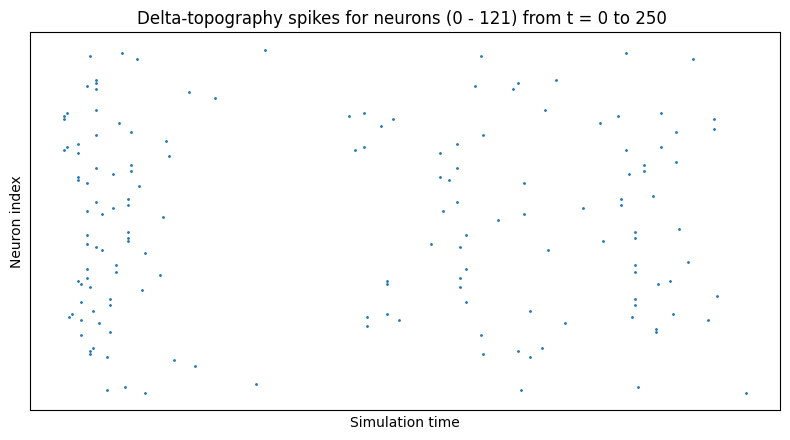

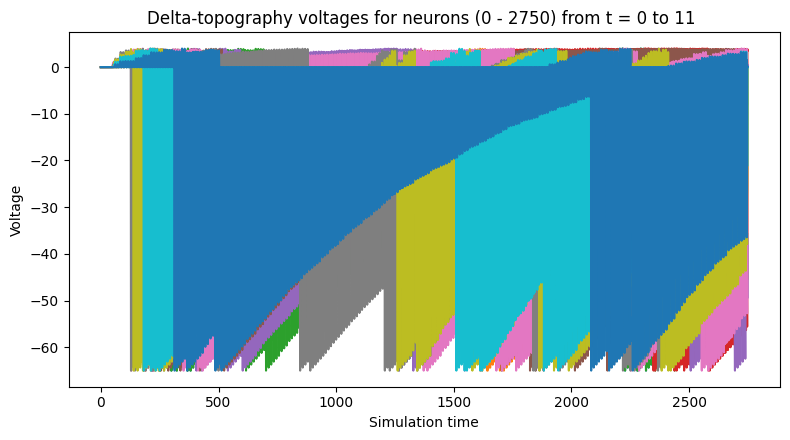

In [6]:
network = bands2topographies['Delta'].to(device)
time = 250
# Create and add input and output layer monitors.

source_monitors = {layer_name:
    Monitor(
      obj=layer,
      state_vars=("s",),  # Record spikes and voltages.
      time=time,  # Length of simulation (if known ahead of time).
    )
    for layer_name, layer in network.layers.items()
    if layer_name.endswith('band')
}
target_monitor = Monitor(
    obj=network.layers[f'{network.band_name}-topography'],
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

for layer_name, source_monitor in source_monitors.items():
  network.add_monitor(monitor=source_monitor, name=layer_name)

network.add_monitor(monitor=target_monitor, name=f'{network.band_name}-topography')

inputs = {}
for layer_name, layer in network.layers.items():
  if not layer_name.endswith('resonators'):
    continue
  # Create input spike data, where each spike is distributed according to Bernoulli(0.1).
  input_data = torch.bernoulli(0.08 * torch.ones(time, layer.n)).byte().to(device)
  inputs[layer_name] = input_data

# Simulate network on input data.
network.run(inputs=inputs, time=time)

# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    # f'{network.band_name} resonators': source_monitor.get("s"),
    # f'{network.band_name} band': target_monitor.get("s")
    f'{network.band_name}-topography': target_monitor.get("s")
}
voltages = {f'{network.band_name}-topography': target_monitor.get("v")}
print(spikes[f'{network.band_name}-topography'].sum())

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()

# Plot weightss chart

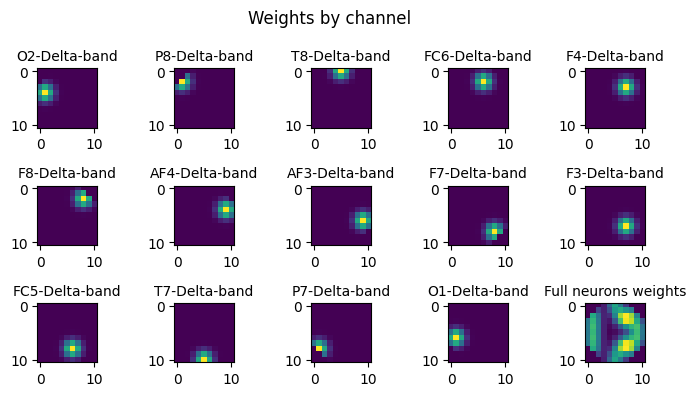

In [7]:
fig, axs = plt.subplots(3, 5, figsize=(7, 4))
i = 0
full_w = torch.zeros((N, N))
for (source_layer_name, target_layer_name), conn in bands2topographies['Delta'].connections.items():
  if not target_layer_name.endswith('topography'):
    continue
  ax = axs[i//5][i%5]
  ax.set_title(source_layer_name, fontsize=10)
  ax.imshow(conn.w.reshape(N,N).cpu())
  full_w += conn.w.reshape(N,N).cpu()
  i += 1

axs[2][4].set_title('Full neurons weights', fontsize=10)
axs[2][4].imshow(full_w)
plt.suptitle('Weights by channel')
plt.tight_layout()
plt.show()

In [8]:
import altair as alt
import pandas as pd
alt.data_transformers.enable('default', max_rows=None)


N = 22

xs = (np.array([-.85, -.66, 0, 0.2, 0.4, 0.7, 0.85,
                0.85, 0.7, 0.4, 0.2, 0, -.66 ,-.85])+1)/2
ys = (-np.array([0.2, 0.6, .95, 0.6, 0.3, 0.6, 0.2,
                 -0.2, -0.6, -0.3, -0.6, -.95, -0.6, -0.2])+1)/2
channels = ['O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4',
            'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', ]

ch_pos = {
    ch: (x, y)
    for ch, (x, y) in zip(channels, zip(ys, xs))
}

ch_pos_N = {k: (int(x * N), int(y * N)) for k, (x, y) in ch_pos.items()}
map_pos2ch = {(vx, vy): k for k, (vx, vy) in ch_pos_N.items()}
gamma_topography = Bands2TopographyLayer('Gamma', resonators2band, shape=(22, 22), ch_pos=ch_pos_N, sigma=N/9)

Ws = []
for (source_layer_name, target_layer_name), conn in gamma_topography.connections.items():
  if not target_layer_name.endswith('topography'):
    continue
  for i, w in enumerate(conn.w.tolist()[0]):
    try:
      t = map_pos2ch[(i // N, i % N)]
    except KeyError:
      t= ''
    Ws.append({
        'ch': source_layer_name.split('-')[0],
        'x': i % N,
        'y': i // N,
        'w': w,
        'T': t,
    })

In [16]:
df = pd.DataFrame(Ws)
range_ = [
   "#7047F5", "#43D6DE", "#5EF556", "#637939", "#E0CF46", "#FF9E4D", "#FA5445",
   "#46E099", "#01FF4B", "#FF4DDC", "#E6A32F", "#8BD4E0", "#FFD2B0", "#61CCFA",
]
main_chart = alt.Chart(df).mark_rect(
).encode(
    x=alt.X('x:N',
         axis=None
    ),
    y=alt.Y('y:N',
         axis=None
    ),
    color=alt.Color('ch', legend=None,
                    scale=alt.Scale(domain=channels, range=range_)),
    opacity=alt.Opacity('w', scale=alt.Scale(range=[0, 1]), legend=None)
)
text_chart = alt.Chart(df).mark_text(
).encode(
    x='x:N',
    y='y:N',
    text='T',
)

chart = (
    main_chart + text_chart
).properties(
    width=450,
    height=450
)

chart

alt.LayerChart(...)

# Training Process

In [24]:
import os
import time
import pickle

from pathlib import Path

main_path = Path('../datasets/EEG_data_for_Mental_Attention_State_Detection/train_test_dataset')

## Training Network!

### Load the Data

In [20]:
trial = '3'
data = {
    'focus': [],
    'unfocus': [],
    'drowsed': [],
}
for label in data.keys():
  for fname in os.listdir(main_path / trial / label):
    with open(main_path / trial / label / fname, 'rb') as f:
      data[label].append({
          f'{k}-resonators': t.T.reshape(t.shape[1], 1, t.shape[0]).to(device)
          for k , t in pickle.load(f).items()
          })
    break

In [21]:
input_layers = [l for l in snn.layers.keys() if l.endswith('resonators')]
len(data['focus'][0]) == len(input_layers)

True

In [22]:
data['focus'][0]['FC5-Delta-resonators'].shape

torch.Size([38400, 1, 10])

In [38]:
t1 = time.time()
sim_time = 153600//4
inputs = data['focus'][0]
label_tensor = torch.tensor([0])
snn.run(inputs=inputs, time=sim_time)
print(time.time() - t1)

490.7493040561676
